In [125]:
# 1d case
# parameterized to use any 01...15 files, but only 1 at a time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = "~/Documents/projects_Spring2018/howe299r/Experiments/03April2018/WIP/"
pos = range(1,16)
IMUDats = [ '%02dIMU.txt'% x for x in pos ]
IMUCols = ['timeSysCal', 'XYZ','X', 'Y', 'Z']

i = 14 #only go up to 15-1 ###EDIT THIS
fname =  '%02dIMU.txt'%(i+1)
imuDat = pd.read_csv(path+fname, header=None,sep=';', 
                    names = IMUCols, usecols=[0,1,2,3,4]) #TODO: this is somehow skipping a col, so the last is NaN. usecols to get around this
imuDat = imuDat.drop(['timeSysCal', 'XYZ'], 1)

# zero calibration are the "even" cols
bkgd = imuDat.iloc[0::2]  #even 
signal = imuDat.iloc[1::2]  #even 

In [126]:
zer = bkgd.as_matrix()
sig = signal.as_matrix()
thetas = sig-zer
#print(thetas.shape)
thetaX, thetaY, thetaZ = thetas[:,0], thetas[:,1], thetas[:,2]

In [127]:
posIdx = range(1,16)
xs = [4.6, 4.1, 3.5, 3.1, 2.6][:-1]#pos 1 x = 4.6 cm
ys = [0.4, 0.1, -0.2]
n = thetas.shape[0]
forces = range(1, n+1) 
forcesZ = [20*f for f in forces]

#pos = np.array([4.6, 0.4, 0]) #01
posIdx = range(1,16)
xs = [4.6, 4.1, 3.5, 3.1, 2.6]#pos 1 x = 4.6 cm
ys = [0.4, 0.0, -0.2]
#ys = [0.4, 0.1, -0.2]
posX = np.array([(x,x,x) for x in xs]).flatten()
posY = np.array(ys *5)
posZ = np.array([0]*15)
#print([i for i in posIdx])
print(len(posX))
pos = np.array([posX[i], posY[i], posZ[i]])

forcesXYZ = np.column_stack((np.zeros((n,2)),forcesZ))
torques = np.cross(forcesXYZ, pos)
torquesX, torquesY, torquesZ = torques[:,0] , torques[:,1], torques[:,2]
print(torques)
#print(torques) #y should be yaw? #"true torque"
np.divide(torques,thetas)
k_hat,resid,rank,s = np.linalg.lstsq(torques, thetas)
estTorque = np.dot(k_hat,thetas.T).T
#print(estTorque)

#print(forcesXYZ)
#print(np.array([posX, posY, posZ]).T)
#print(pos)

15
[[   4.   52.   -0.]
 [   8.  104.   -0.]
 [  12.  156.   -0.]
 [  16.  208.   -0.]
 [  20.  260.   -0.]
 [  24.  312.   -0.]
 [  28.  364.   -0.]
 [  32.  416.   -0.]
 [  36.  468.   -0.]
 [  40.  520.   -0.]
 [  44.  572.   -0.]
 [  48.  624.   -0.]
 [  52.  676.   -0.]
 [  56.  728.   -0.]
 [  60.  780.   -0.]
 [  64.  832.   -0.]
 [  68.  884.   -0.]
 [  72.  936.   -0.]
 [  76.  988.   -0.]
 [  80. 1040.   -0.]
 [  84. 1092.   -0.]
 [  88. 1144.   -0.]
 [  92. 1196.   -0.]
 [  96. 1248.   -0.]
 [ 100. 1300.   -0.]
 [ 104. 1352.   -0.]
 [ 108. 1404.   -0.]
 [ 112. 1456.   -0.]
 [ 116. 1508.   -0.]
 [ 120. 1560.   -0.]
 [ 124. 1612.   -0.]
 [ 128. 1664.   -0.]
 [ 132. 1716.   -0.]
 [ 136. 1768.   -0.]
 [ 140. 1820.   -0.]
 [ 144. 1872.   -0.]
 [ 148. 1924.   -0.]
 [ 152. 1976.   -0.]
 [ 156. 2028.   -0.]
 [ 160. 2080.   -0.]
 [ 164. 2132.   -0.]
 [ 168. 2184.   -0.]
 [ 172. 2236.   -0.]
 [ 176. 2288.   -0.]
 [ 180. 2340.   -0.]]


/home/nrw/Documents/projects_Spring2018/howe299r/Experiments/venv/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning:

divide by zero encountered in true_divide

/home/nrw/Documents/projects_Spring2018/howe299r/Experiments/venv/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning:

`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.



In [132]:
%matplotlib tk
import plotly.plotly as py
import plotly.offline as po
import plotly.graph_objs as go
from sklearn import linear_model
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error, r2_score

po.init_notebook_mode(connected=True)

trace0 = go.Scatter( x = torquesY, y = thetaY, mode = 'markers',
    name = 'degrees (by IMU)' )

#forcesXYZ = forcesXYZ.reshape(-1, 1)
myX = torquesY.reshape(-1,1)
print(len(forcesXYZ))
myy = thetaY 
print(len(thetas))
#regr= Ridge(fit_intercept=True, alpha=1.0, random_state=0, normalize=True)
regr = linear_model.LinearRegression()
regr.fit(myX, myy)
coef_ridge = regr.coef_
gridx = np.linspace(myX.min(), myX.max(), 20)
coef_ = regr.coef_ * gridx + regr.intercept_
yPred= regr.predict(myX) 
#plt.plot(gridx, coef_, 'g-', label="ridge regression")

trace2 = go.Scatter( x= gridx, y = coef_,
    name = 'linear fit (w/ridge penalty)' )

data = [trace0, trace2]
    
    
layout = go.Layout(
    title='Torque vs Degrees of Deflection (pitch)',
    yaxis=dict(title='degrees'),
    xaxis=dict(title='torque (in grams)'),
    legend=dict(x=.1, y=-.5) )

fig = go.Figure(data=data, layout=layout)
# Plot and embed in ipython notebook!

print('Coefficients: \n', regr.coef_)
print("Mean squared error: %.2f" % mean_squared_error(thetaY, yPred))
#print('Variance score (ideal 1): %.2f' % r2_score(thetaY))
po.iplot(fig)

45
45
Coefficients: 
 [-0.00678065]
Mean squared error: 0.29


In [129]:
%matplotlib tk
resid = thetaY - yPred 
traceResid = go.Scatter( x = thetaY, y = resid, mode = 'markers',
    name = 'resid vs trueY' )
traceResid2 = go.Scatter( x = yPred, y = resid, mode = 'markers', 
                         marker=dict(size='5', color='red'),
                        name = 'resid vs estY')
data = [traceResid, traceResid2]
layout = go.Layout(
    title='Residuals',
    yaxis=dict(title='residuals'),
    xaxis=dict(title='yIMU (degrees)'),
    legend=dict(x=.1, y=-.5) )

fig = go.Figure(data=data, layout=layout)
po.iplot(fig)
print(thetaY)
print(resid)

[ -0.5625  -0.6875  -0.5625  -1.625   -1.4375  -1.375   -2.125   -2.0625
  -2.0625  -3.25    -2.875   -3.3125  -3.5625  -4.0625  -3.875   -4.9375
  -4.8125  -4.9375  -6.125   -5.5625  -5.125   -7.1875  -7.0625  -6.875
  -7.8125  -8.0625  -8.75    -8.6875  -9.      -9.25    -9.75   -10.3125
 -10.625  -11.9375 -10.875  -11.8125 -13.125  -13.0625 -13.1875 -13.25
 -14.4375 -14.4375 -15.375  -15.     -15.5625]
[-0.97789855 -0.75030468 -0.2727108  -0.98261693 -0.44252306 -0.02742918
 -0.42483531 -0.00974144  0.34285244 -0.49205369  0.23554018  0.15063406
  0.25322793  0.10582181  0.64591568 -0.06399045  0.41360343  0.6411973
 -0.19370883  0.72138505  1.51147892 -0.19842721  0.27916667  0.81926054
  0.23435441  0.33694829  0.00204216  0.41713603  0.45722991  0.55982378
  0.41241765  0.20251153  0.2426054  -0.71730072  0.69779315  0.11288702
 -0.8470191  -0.43192523 -0.20433136  0.08576252 -0.74914361 -0.39654974
 -0.98145586 -0.25386199 -0.46376812]


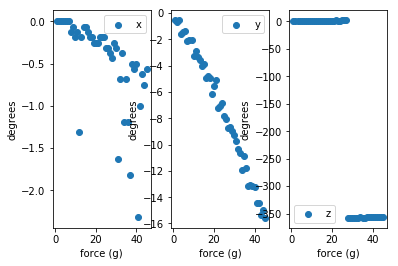

In [130]:
%matplotlib inline
plt.subplot(131)
plt.scatter(forces, thetaX, label='x')
plt.ylabel('degrees')
plt.xlabel('force (g)')
plt.legend()
plt.subplot(132)
plt.scatter(forces, thetaY, label='y')
plt.ylabel('degrees')
plt.xlabel('force (g)')
plt.legend()
plt.subplot(133)
plt.scatter(forces, thetaZ, label='z')
plt.ylabel('degrees')
plt.xlabel('force (g)')
plt.legend()
plt.show()

In [131]:
import numpy as np
import plotly.plotly as py
import plotly.offline as po
import plotly.graph_objs as go
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

po.init_notebook_mode(connected=True)
trace0 = go.Scatter( x = forces, y = yIMU, mode = 'markers',
    name = 'degrees (by IMU)' )

forces = forces.reshape(-1, 1)
myX = forces
myy = yIMU 
#regr= Ridge(fit_intercept=True, alpha=1.0, random_state=0, normalize=True)
regr = linear_model.LinearRegression()
regr.fit(myX, myy)
coef_ridge = regr.coef_
gridx = np.linspace(myX.min(), myX.max(), 20)
coef_ = regr.coef_ * gridx + regr.intercept_
yPred= regr.predict(myX) 
#plt.plot(gridx, coef_, 'g-', label="ridge regression")

trace2 = go.Scatter( x= gridx, y = coef_,
    name = 'linear fit (w/ridge penalty)' )
           

NameError: name 'yIMU' is not defined

In [ ]:
#kest = torques / thetas
# thetas 21.3

# forces 21.3 
# pos 1.3 
#torques 21.3

